<a href="https://colab.research.google.com/github/rishisethia258/PINN-2d-final/blob/main/PINN_1d_Neumann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libraries
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
!pip install deepxde
from deepxde.backend import tf
import deepxde as dde
import numpy as np
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 11.8 MB/s eta 0:00:00
No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Enable just-in-time compilation with XLA.



In [2]:
# Constants
LENGTH_OF_DOMAIN = 1
TIME = 1
INITIAL_CONC = 0
D = 0.4
J = 1

In [3]:
# Domain Definition
LineDomain = dde.geometry.Interval(0, LENGTH_OF_DOMAIN)
TimeDomain = dde.geometry.TimeDomain(0, TIME)
CombinedDomain = dde.geometry.GeometryXTime(LineDomain, TimeDomain)

In [4]:
# Boundary Condition
def l_boundary(X, on_boundary):
  return on_boundary and np.isclose(X[0], 0)

l_bc = dde.icbc.NeumannBC(CombinedDomain, lambda X : J / D, l_boundary)
initial_bc = dde.icbc.IC(CombinedDomain, lambda X : INITIAL_CONC, lambda _, on_initial : on_initial)

In [5]:
# PDE definition
def pde(X, u):
  du_dt = dde.grad.jacobian(u, X, i = 0, j = 1)
  ddc_dxx = dde.grad.hessian(u, X, i = 0, j = 0)
  return du_dt - D * (ddc_dxx)

In [6]:
# PDE module
module = dde.data.TimePDE(
    CombinedDomain,
    pde,
    [l_bc, initial_bc],
    num_domain = 5000,
    num_boundary = 1200,
    num_initial = 1200,
    num_test = 5000,
)

In [7]:
# Defining and Compiling Model
net = dde.nn.FNN([2] + [100] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(module, net)
model.compile("adam", lr = 0.001)

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


Compiling model...
Building feed-forward neural network...
'build' took 0.076768 s

'compile' took 3.259882 s



Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.08e-02, 5.38e+00, 1.10e-02]    [2.02e-02, 5.38e+00, 1.10e-02]    []  
1000      [7.33e-04, 9.94e-04, 6.05e-03]    [3.68e-04, 9.94e-04, 6.05e-03]    []  
2000      [2.66e-04, 3.20e-04, 1.69e-03]    [2.17e-04, 3.20e-04, 1.69e-03]    []  
3000      [9.82e-05, 2.02e-04, 1.28e-03]    [7.37e-05, 2.02e-04, 1.28e-03]    []  
4000      [1.51e-04, 2.76e-04, 1.05e-03]    [1.23e-04, 2.76e-04, 1.05e-03]    []  
5000      [5.34e-04, 1.60e-04, 8.82e-04]    [2.22e-04, 1.60e-04, 8.82e-04]    []  
6000      [1.93e-03, 3.89e-03, 8.96e-04]    [1.14e-03, 3.89e-03, 8.96e-04]    []  
7000      [2.16e-04, 5.05e-04, 6.17e-04]    [1.56e-04, 5.05e-04, 6.17e-04]    []  
8000      [5.72e-05, 9.35e-05, 5.03e-04]    [5.49e-05, 9.35e-05, 5.03e-04]    []  
9000      [8.90e-05, 1.11e-04, 4.35e-04]    [5.99e-05, 1.11e-04, 4.35e-04]    []  
10000     [1.14e-04, 7.83e-05, 3.79

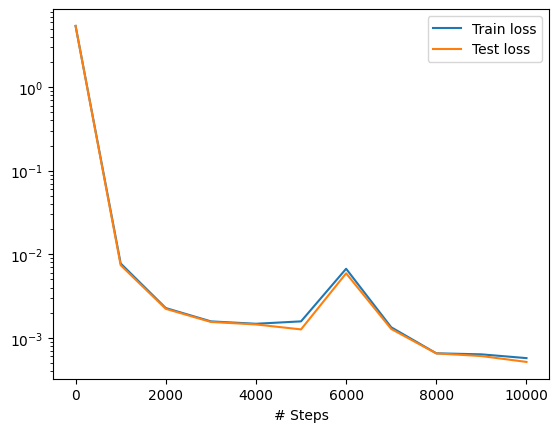

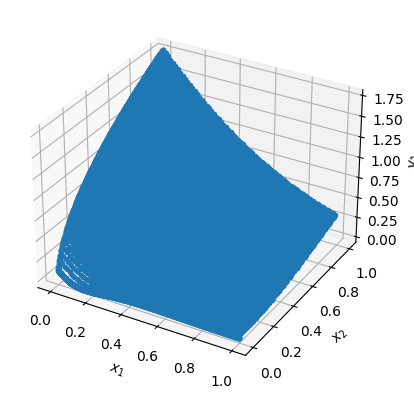

In [8]:
# Training Model
LossHistory, TrainState = model.train(iterations = 10000)
dde.saveplot(LossHistory, TrainState, issave = True, isplot = True)

In [20]:
# Finding PINN Solution
ux = np.linspace(0, LENGTH_OF_DOMAIN, (LENGTH_OF_DOMAIN * 30) + 1, dtype = "float")
ut = np.linspace(0, TIME, (TIME * 20) + 1, dtype = "float")
x, t = np.meshgrid(ux, ut)
X = np.array([x.flatten(), t.flatten()]).T

predicted_c = model.predict(X)
model_X_pinn = np.insert(X, [1], predicted_c.reshape((-1, 1)), axis = 1)

In [21]:
# Finding Analytical Solution
from math import erfc,sqrt
def ref_sol(x, t):
  if np.isclose(t, 0):
    return 0
  u = (J / np.sqrt(D)) * (2 * np.sqrt(t / np.pi) * np.exp(-x**2 / (4 * D * t)) - ((x / np.sqrt(D)) * math.erfc(x / (2 * np.sqrt(D * t)))))
  return u

def gen_exactSol(X):
  y = np.zeros(len(X))
  for i in range(len(X)):
    y[i] = ref_sol(X[i][0], X[i][1])
  return y

y = gen_exactSol(X)
model_X_analytical = np.insert(X, [1], y.reshape((-1, 1)), axis = 1)

In [22]:
# Plotting Class for comparision
class plotly_compare():
  
  def __init__(self, arr_X, name_models):
    if len(arr_X) != len(name_models):
      raise NotImplementedError("X and name arr are of different lengths i.e. {} and {}".format(len(arr_X), len(name_models)))
    if len(arr_X) == 0 or len(arr_X[0]) < 2 :
      raise NotImplementedError("Please check dimensions of X")
    self.arr_X = arr_X
    self.name_models = name_models
    self.nuller = np.zeros(len(arr_X[0]), dtype = "float").reshape(-1,1)
    if len(arr_X[0][0]) == 2:
      for i in range(len(arr_X)):
        arr_X[i] = np.insert(arr_X[i],[0], self.nuller, axis = 1)
    if len(arr_X[0][0]) == 3:
      for i in range(len(arr_X)):
        arr_X[i] = np.insert(arr_X[i], [2], self.nuller, axis = 1)
    self.arr_n = np.array([])
    for X in arr_X:
      self.arr_n = np.append(self.arr_n, len(X))
    self.color_row = np.array([])
    for i in range(len(self.arr_n)):
      self.color_row = np.hstack((self.color_row, np.repeat(name_models[i], self.arr_n[i])))
    self.x = np.array([])
    self.y = np.array([])
    self.t = np.array([])
    self.u = np.array([])
    for i in range(len(arr_X)):
      self.x = np.hstack((self.x,np.array(arr_X[i][:, 0 : 1]).flatten()))
      self.y = np.hstack((self.y,np.array(arr_X[i][:, 1 : 2]).flatten()))
      self.u = np.hstack((self.u,np.array(arr_X[i][:, 2 : 3]).flatten()))
      self.t = np.hstack((self.t,np.array(arr_X[i][:, 3 : 4]).flatten()))
    self.unified_X = np.array([self.x, self.y, self.u, self.t, self.color_row]).T
  
  def creater_plot(self, x = None, y = None, t = None, error_range = 0.0001) :
    df = pd.DataFrame()
    def fil(X):
      cond = True 
      if x is not None:
        cond = (cond and abs(round(float(X[0]),2)-x)<=error_range)
      if y is not None :
        cond = (cond and abs(round(float(X[1]),2)-y)<=error_range)
      if t is not None:
        cond = (cond and abs(round(float(X[3]),2)-t)<=error_range)
      return cond
    filtered_X = self.unified_X[np.array(list(map(fil, self.unified_X)))]
    df["x"] = filtered_X[:, 0 : 1].flatten().astype("float64").round(3)
    df["u"] = filtered_X[:, 1 : 2].flatten().astype("float64").round(8)
    df["color_row"] = filtered_X[:, 4 : 5].flatten()
    df.sort_values(by = "x")
    fig  = px.line(df, x = "x", y = "u", color = "color_row", title = "time frame:{}s".format(t), hover_data = "x")
    y_org = df[df["color_row"] == "pinn"]
    x_org = y_org["x"]
    y_org = y_org["u"]
    y_cal = df[df["color_row"] == "analytical"]
    x_cal = y_cal["x"]
    y_cal = y_cal["u"]
    plt.plot(x_org, y_org, "-*")
    plt.plot(x_cal, y_cal)
    plt.legend(["PINN", "Analytical"], loc = "best")
    plt.title(f"Time frame: {round(t, 2)}s")
    plt.xlabel("distance")
    plt.ylabel("concentration")
    plt.ylim((0, 2))
    plt.show()
    return fig

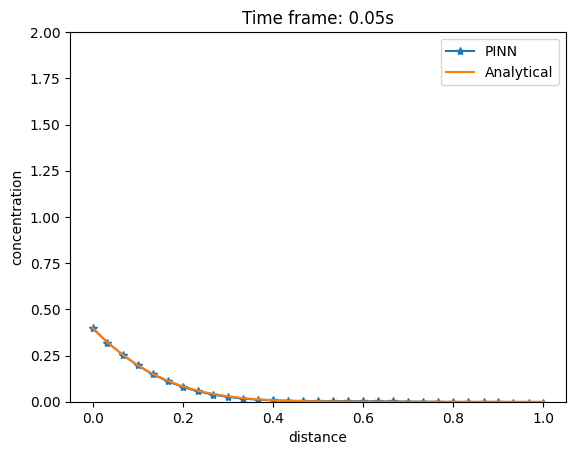

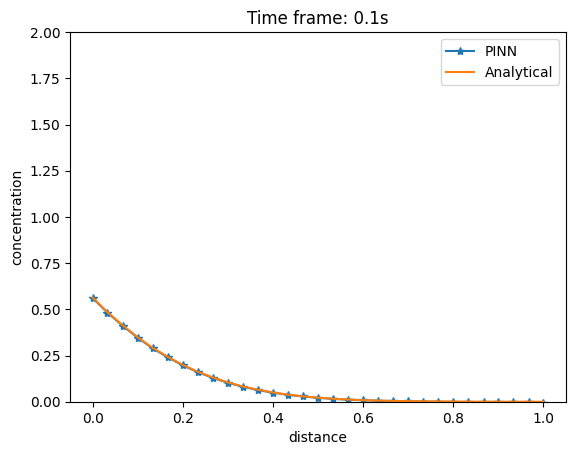

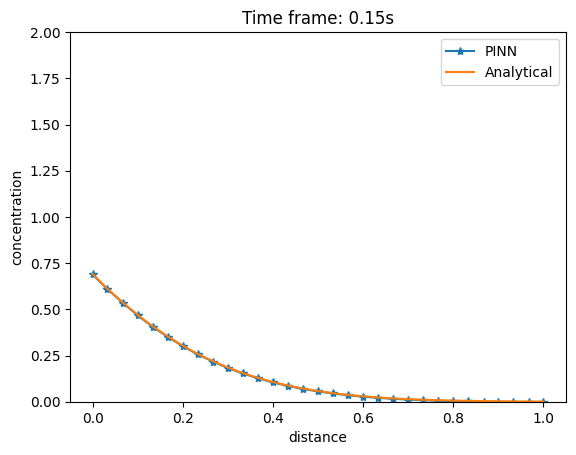

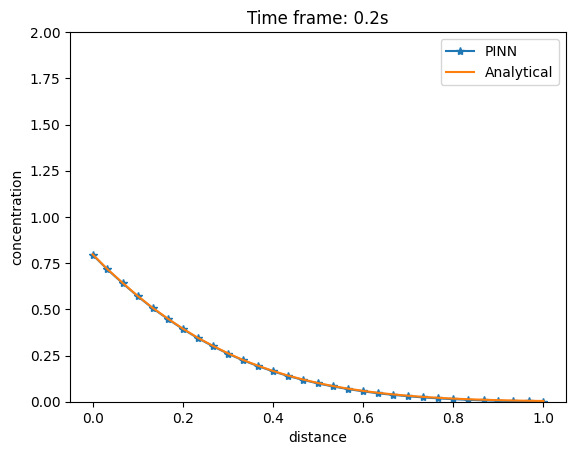

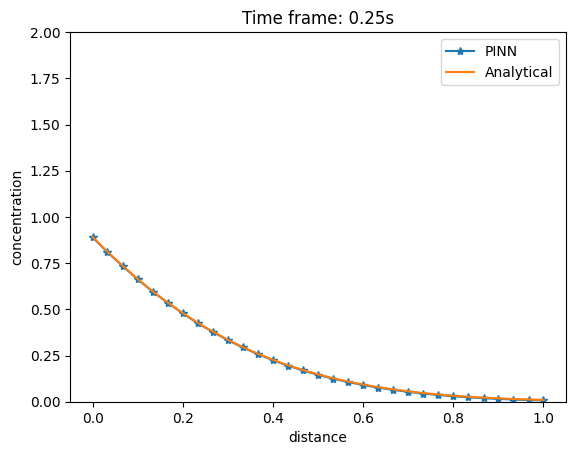

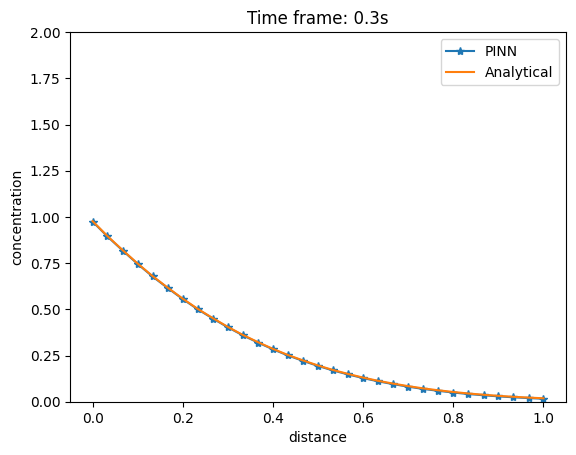

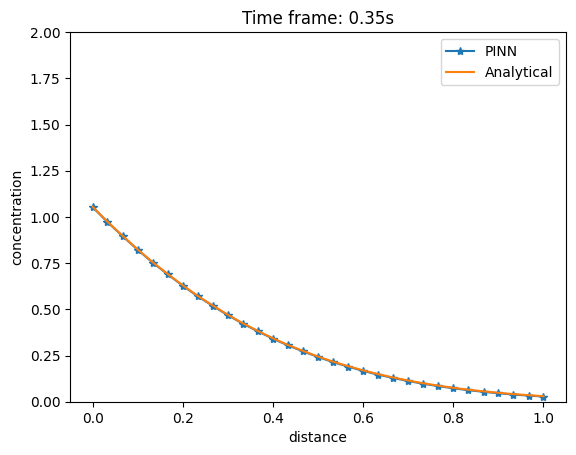

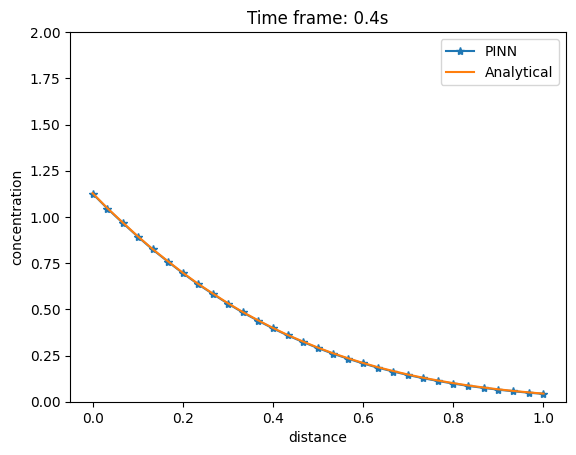

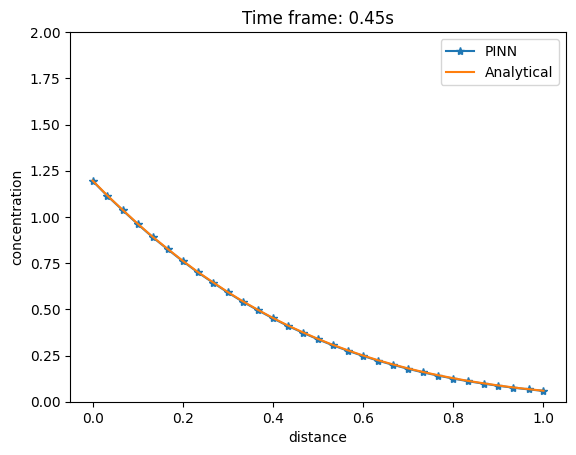

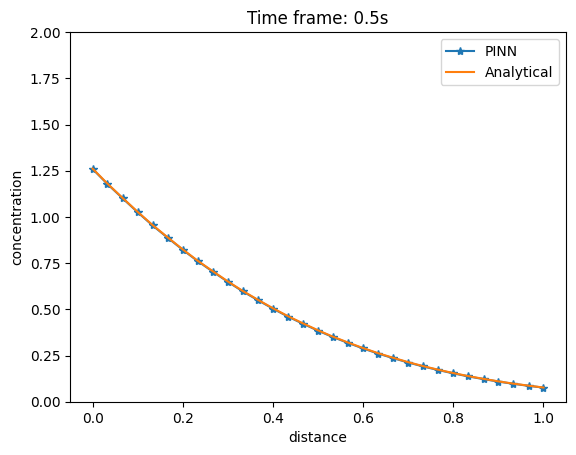

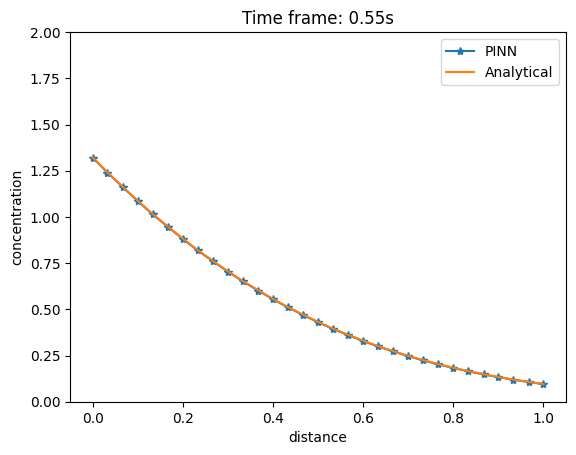

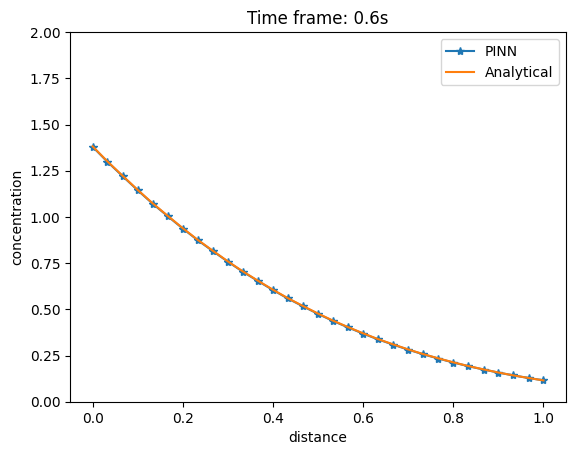

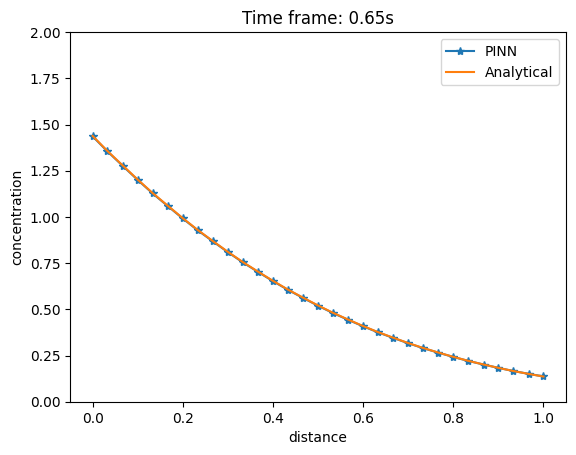

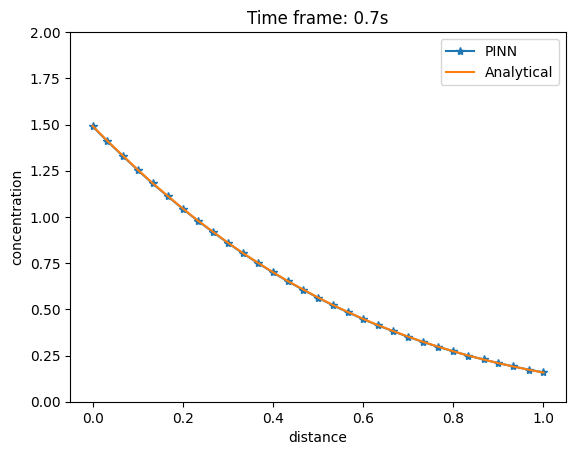

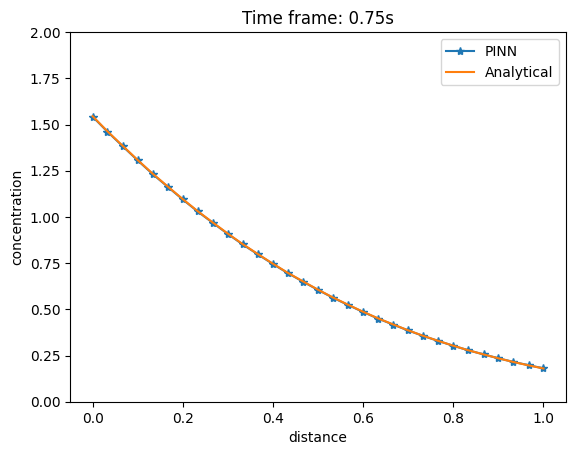

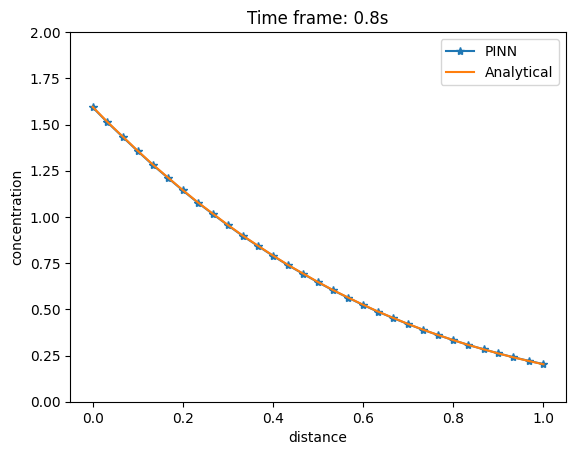

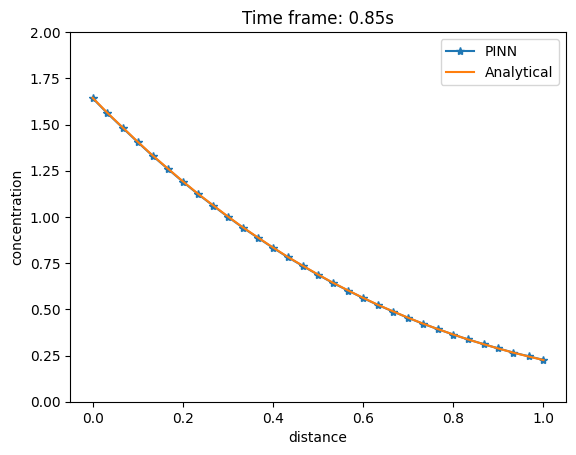

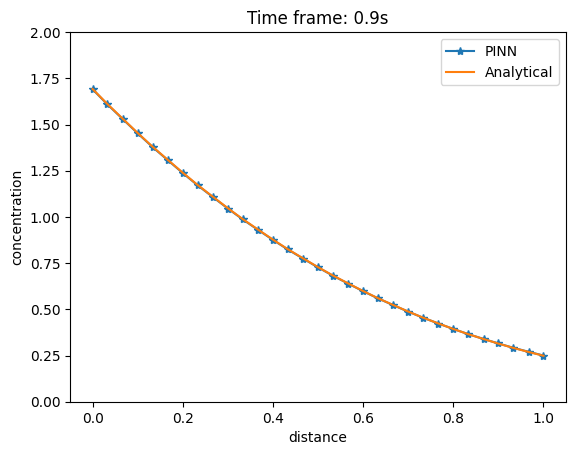

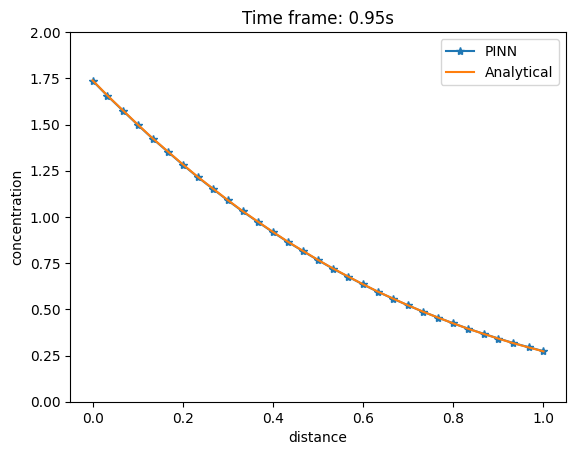

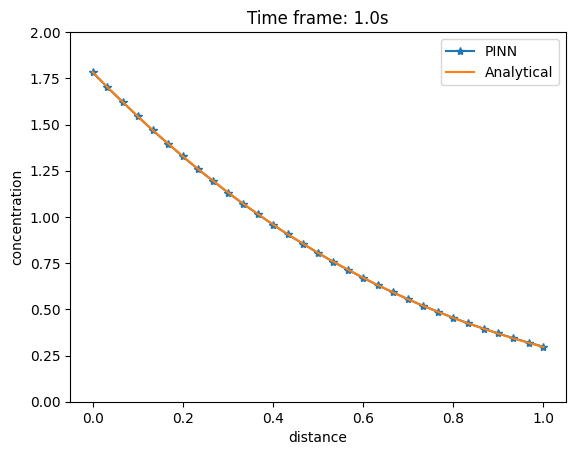

In [23]:
# Plotting Comparision graphs
comparision = plotly_compare([model_X_pinn, model_X_analytical], ["pinn", "analytical"])
for i in range(1, len(ut)):
  fig = comparision.creater_plot( t = ut[i], error_range = 0.01)